In [1]:
# !pip install tldextract

In [2]:
# !pip install kmodes

In [4]:
# !pip install -U scikit-learn

In [5]:
%matplotlib inline

In [6]:
# define random seed to make the code deterministically reproducible
import os
import random

# open json files
import json

# read the data
import pandas as pd
from pandas import json_normalize

# linear algebra utilities
import numpy as np

# data clean
import re
import string

# tokenize data
from nltk import word_tokenize
from nltk.corpus import stopwords

# extract domain name
# import tldextract

# sklearn gives an easy interface to the clustering model
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# visualizations
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import seaborn as sns

# define column width and allow showing all rows and columns (optional)
pd.options.display.max_colwidth=200
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# define SEED and set it as random using numpy, random, and the PYTHONHASHSEED environment variable
# to make code reproducible across systems
SEED = 42
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)


In [7]:
with open('docs.json', encoding="utf8") as f:
    data = json.load(f)
# print(data)

In [8]:
docs = json_normalize(data['hits']['hits'])

## Data exploration and tudying

In [9]:
docs.shape

(300, 42)

In [10]:
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   _index                    300 non-null    object 
 1   _type                     300 non-null    object 
 2   _id                       300 non-null    object 
 3   _score                    300 non-null    int64  
 4   _source.mediaitemid       300 non-null    int64  
 5   _source.summaryid         300 non-null    object 
 6   _source.programid         300 non-null    int64  
 7   _source.commentatorid     300 non-null    int64  
 8   _source.headline          300 non-null    object 
 9   _source.datecreated       300 non-null    object 
 10  _source.airdate           300 non-null    object 
 11  _source.searchabletext    300 non-null    object 
 12  _source.abstract          300 non-null    object 
 13  _source.fulltext          158 non-null    object 
 14  _source.pr

In [11]:
docs.head(2)

,_index,_type,_id,_score,_source.mediaitemid,_source.summaryid,_source.programid,_source.commentatorid,_source.headline,_source.datecreated,_source.airdate,_source.searchabletext,_source.abstract,_source.fulltext,_source.programname,_source.sourcename,_source.mediatype,_source.commentator,_source.articletype,_source.sourcesystem,_source.state,_source.country,_source.entityname,_source.socialuserid,_source.twitterfollowers,_source.twitterfollowing,_source.twitterposts,_source.buzzresultid,_source.username,_source.displayname,_source.profileurl,_source.picturefolder,_source.picturecount,_source.hyperlink,_source.mediaoutletlogo,_source.mediatypeid,_source.companyname,_source.deliverysetname,_source.briefname,_source.prospectkeyword,_source.@version,_source.@timestamp
0,demo1,logs,AVf1MzEjpI2L3kY8EWkf,1,232128474,649151843,79006,6925,Taiwan's budget carrier V Air to cease operations,2016-08-29T17:45:10.873Z,2016-09-01T00:00:00.000Z,"<root><item><id xml:lang=""en-US"">649151843</id><head xml:lang=""en-US"">Taiwan's budget carrier V Air to cease operations</head><abs xml:lang=""en-US"">Taiwanese regional budget carrierV Air will go o...","Taiwanese regional budget carrierV Air will go out of business in October after less than two years of operation because of competition and low passenger loads, pointing to saturation in its homel...","\r\n Taiwanese regional budget carrierV Air will go out of business in October after less than two years of operation because of competition and low passenger loads, pointing to saturation in i...",General News,Asian Aviation,Magazine,None,News Item,Press,National,Australia,Asian Aviation,NaN,NaN,NaN,NaN,None,None,None,None,None,None,,None,15,Etihad Airways,My133 3,Competitors Press,"Airways,announced,business,capital,industry,launched,plan,planned,route,routes,service,staff,take over,Tigerair,venture",1,2016-10-24T05:39:14.405Z
1,demo1,logs,AVf1MzEjpI2L3kY8EWkg,1,232130228,649157337,79006,645731,China high on AirAsia wishlist,2016-08-29T18:06:10.700Z,2016-09-01T00:00:00.000Z,"<root><item><id xml:lang=""en-US"">649157337</id><head xml:lang=""en-US"">China high on AirAsia wishlist</head><abs xml:lang=""en-US"">AAV European contributor Ian Goold explains why paying for dinner s...",AAV European contributor Ian Goold explains why paying for dinner sometimes pays off in business. WHEN AIRASIA GROUP CHIEF EXECUTIVE Tony Femandes paid for a meal with Airbus chief operating offic...,\r\n AAV European contributor Ian Goold explains why paying for dinner sometimes pays off in business.\r\n\r\n WHEN AIRASIA GROUP CHIEF EXECUTIVE Tony Femandes paid for a meal with Airbus ch...,General News,Asian Aviation,Magazine,Lan Goold,News Item,Press,National,Australia,Asian Aviation,NaN,NaN,NaN,NaN,None,None,None,None,None,None,,None,15,Qantas Airways Ltd,My133 3,Jetstar - Press,"Femandes,Fernandes,Tony",1,2016-10-24T05:39:14.439Z


In [12]:
# clean column names
docs.columns = docs.columns.str.replace(r'_source.', '', regex=False)

In [13]:
# rename columns for better understanding of content
docs.rename(columns=(
    {
        '_index': 'index',
        '_type': 'type',
        '_id': 'id',
        '_score': 'score',
        'mediaitemid': 'media_item_id', 
        'summaryid': 'summary_id',
        'programid': 'program_id',
        'commentatorid': 'commentator_id',
        'datecreated': 'date_created',
        'airdate': 'air_date',
        'searchabletext': 'searchable_text',
        'fulltext': 'full_text',
        'programname': 'program_name',
        'sourcename': 'source_name',
        'mediatype': 'media_type',
        'articletype': 'article_type',
        'sourcesystem': 'source_system',
        'entityname': 'entity_name',
        'mediaoutletlogo': 'media_outlet_logo',
        'mediatypeid': 'media_type_id',
        'companyname': 'company_name',
        'deliverysetname': 'delivery_set_name',
        'briefname': 'brief_name',
        'prospectkeyword': 'prospect_keyword',
        '@version': 'version',
        '@timestamp': 'time_stamp'
    }
), inplace=True)

There are several columns where over 90 percent of the values are null - columns 23 to 32. They are not useful for the purpose of clustering and will be will be removed. 

In [14]:
docs.drop(
    [
        'socialuserid', 
        'twitterfollowers', 
        'twitterfollowing', 
        'twitterposts', 
        'buzzresultid', 
        'username', 
        'displayname',
        'profileurl', 
        'picturefolder',
        'picturecount',
    ], axis=1, inplace=True)

In [15]:
print(docs['index'].unique())
print(docs['type'].unique())
print(docs['score'].unique())
print(docs['version'].unique())

['demo1']
['logs']
[1]
['1']


In [16]:
docs[docs['prospect_keyword'].isna()]

,index,type,id,score,media_item_id,summary_id,program_id,commentator_id,headline,date_created,air_date,searchable_text,abstract,full_text,program_name,source_name,media_type,commentator,article_type,source_system,state,country,entity_name,hyperlink,media_outlet_logo,media_type_id,company_name,delivery_set_name,brief_name,prospect_keyword,version,time_stamp
195,demo1,logs,AVf1M2q7pI2L3kY8EXDb,1,232987222,652775603,115331,10702,TravelDEALS,2016-09-06T10:54:11.123Z,2016-09-06T00:00:00.000Z,"<root><item><id xml:lang=""en-US"">652775603</id><head xml:lang=""en-US"">TravelDEALS</head><abs xml:lang=""en-US"">NULL</abs><prg xml:lang=""en-US"">Arts &amp; Entertainment</prg><loc xml:lang=""en-US"">Si...",NULL,"\r\n j^-jtravelDEALS\r\n\r\n Win a car! Planning your next holiday? Visit the three-day ASA Comes Closer to You @ Junction 8 Travel Fair for destination ideas and attractive promotions, incl...",Arts & Entertainment,The Straits Times,Newspaper,No author available,News Item,Press,SIN,Singapore,The Straits Times,,logo_11341.jpg,6,Qantas Airways Ltd,My133 3,T: SEA Monitoring,None,1,2016-10-24T05:39:29.828Z
230,demo1,logs,AVf1M3g2pI2L3kY8EXMc,1,233119718,653312350,116522,6925,Trade Set To Benefit From EK Changes,2016-09-07T09:45:11.017Z,2016-09-06T00:00:00.000Z,"<root><item><id xml:lang=""en-US"">653312350</id><head xml:lang=""en-US"">Trade Set To Benefit From EK Changes</head><abs xml:lang=""en-US"">The main retail chains have welcomed EK's plans to start flyi...","The main retail chains have welcomed EK's plans to start flying A380 services to Christchurch, and offer a daily A380 Bangkok service ex Auckland (via Sydney), as the travel agent distribution loo...","\r\n The main retail chains have welcomed EK's plans to start flying A380 services to Christchurch, and offer a daily A380 Bangkok service ex Auckland (via Sydney), as the travel agent distribu...",General News,Travel Today,Magazine,None,News Item,Press,NZ,New Zealand,None,,None,15,Qantas Airways Ltd,My133 3,A: Qantas,None,1,2016-10-24T05:39:32.879Z


We will drop these columns: **index**, **type**, **score**, and **version** since they contain a single value which cannot be used to group the data.

**media_outlet_logo** column will not be used since it contains jpg filenames that do not give useful information for grouping the articles. 

The date columns: **date_created**, **air_date**, **time_stamp** are also irrelevant to the task. 

The columns **full_text** and **entity_name** could be useful but more than one third and respectively more than half of the data is null in these columns. Since it is not a numerical data we cannot impute mean or duplicate values. We cannot afford to drop the rows either since we will be left with very little data to work with.

There are only two rows with missing data in **prospect_keyword** column, so we can drop these rows.

As for **article_type** we need to explore the possibility to add value based on simillarity with other columns.

We also do not need **state** and **country**. 

We are clustering the articles by the content they provide.

In [17]:
docs.drop(
    [
        'index', 
        'type', 
        'score', 
        'version', 
        'media_outlet_logo', 
        'date_created', 
        'air_date',
        'time_stamp',
        'entity_name',
        'full_text',
        'state', 
        'country',
    ], axis=1, inplace=True)

In [18]:
docs = docs[docs['prospect_keyword'].notna()]

In [19]:
docs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 299
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 298 non-null    object
 1   media_item_id      298 non-null    int64 
 2   summary_id         298 non-null    object
 3   program_id         298 non-null    int64 
 4   commentator_id     298 non-null    int64 
 5   headline           298 non-null    object
 6   searchable_text    298 non-null    object
 7   abstract           298 non-null    object
 8   program_name       298 non-null    object
 9   source_name        298 non-null    object
 10  media_type         298 non-null    object
 11  commentator        298 non-null    object
 12  article_type       282 non-null    object
 13  source_system      298 non-null    object
 14  hyperlink          298 non-null    object
 15  media_type_id      298 non-null    int64 
 16  company_name       298 non-null    object
 1

In [20]:
grouped = pd.DataFrame({'count': docs.groupby(['article_type', 'media_type', 'source_system'], dropna=False).size()}).reset_index()

In [21]:
grouped

,article_type,media_type,source_system,count
0,Internet Item,Internet,Internet,126
1,Letter,Newspaper,Press,5
2,News Item,Magazine,Press,27
3,News Item,Newspaper,Press,124
4,NaN,Blog,Internet,5
5,NaN,Images and Video,Internet,1
6,NaN,Social Network,Internet,10


In [22]:
docs[docs['media_type']=='Images and Video']

,id,media_item_id,summary_id,program_id,commentator_id,headline,searchable_text,abstract,program_name,source_name,media_type,commentator,article_type,source_system,hyperlink,media_type_id,company_name,delivery_set_name,brief_name,prospect_keyword
274,AVf1M4HGpI2L3kY8EXPV,233199690,653549116,322837,10034676,Jess and Cam at the BankWest Leading Intergenerational Change Lunch. An event to inspire the leaders,"<root><item><id xml:lang=""en-US"">653549116</id><head xml:lang=""en-US"">Jess and Cam at the BankWest Leading Intergenerational Change Lunch. An event to inspire the leaders</head><abs xml:lang=""en-U...",Jess and Cam at the BankWest Leading Intergenerational Change Lunch. An event to inspire the leaders of tomorrow.,Other,Instagram,Images and Video,sproutadl,None,Internet,https://www.instagram.com/p/BKDJcO-htRs/,14,Bankwest,My133 3,Bankwest - Social,"#bankwest,BankWest"


The records with Nan values in **article_type** include media type records such as Blog and Social Network. I will name it Social Media.

In [23]:
docs['article_type'].fillna('Social Media', inplace=True)

In [24]:
# Plot data
def display_groups(df, col_name, title):
    types = pd.DataFrame()
    types['count'] = df.groupby(col_name)['id'].count()

    fig = plt.figure(figsize=(8, 3))
    plt.style.use('fivethirtyeight')
    ax = fig.add_axes([0,0,1,1])
    plt.xticks(rotation=90)
    plt.title(title)
    ax.bar(types.index, types['count'], color='teal')

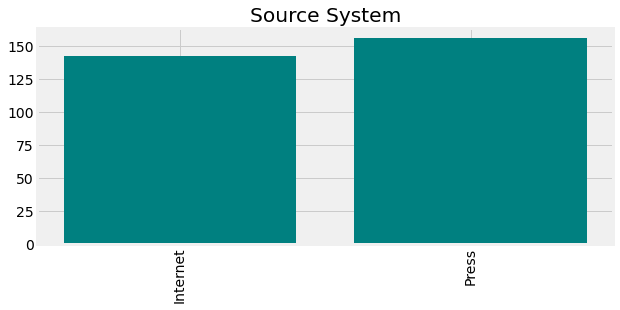

In [25]:
display_groups(docs, 'source_system', 'Source System')

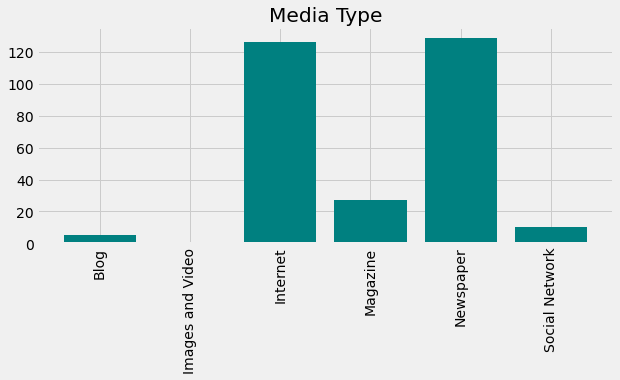

In [26]:
display_groups(docs, 'media_type', 'Media Type')

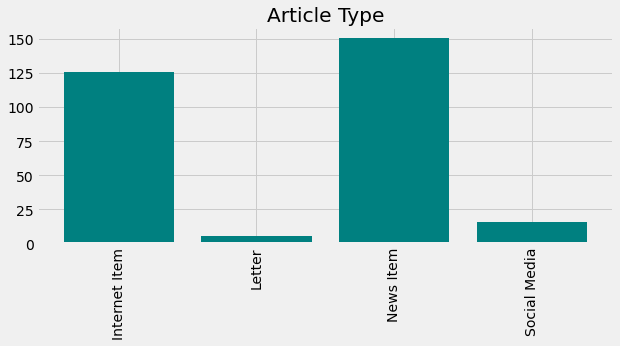

In [27]:
display_groups(docs, 'article_type', 'Article Type')

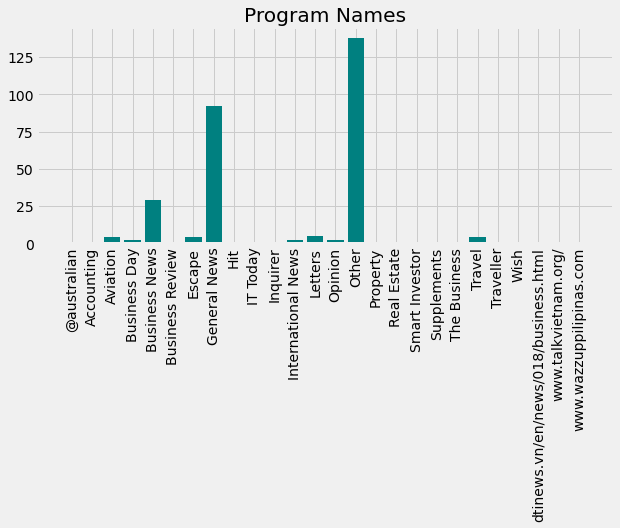

In [28]:
display_groups(docs, 'program_name', 'Program Names')

In [29]:
# there are several columns which seem to have a connection and we need to check that
docs.groupby(['media_type', 'media_type_id'], dropna=False).size().reset_index()

,media_type,media_type_id,0
0,Blog,12,5
1,Images and Video,14,1
2,Internet,7,126
3,Magazine,15,27
4,Newspaper,6,129
5,Social Network,10,10


In [30]:
docs.groupby(['commentator', 'commentator_id'], dropna=False).size().reset_index().head()

,commentator,commentator_id,0
0,3news.co.nz editor,4788900,1
1,AFP,9112,1
2,AMY HAYDOCK,959737,1
3,Aaron Greenwood,95472,1
4,Adele Ferguson Mario Christodoulou,9830684,1


In [31]:
docs.groupby(['program_name', 'program_id'], dropna=False).size().reset_index().head(10)

,program_name,program_id,0
0,@australian,1239084,1
1,Accounting,198977,1
2,Aviation,55252,4
3,Business Day,78953,2
4,Business News,47600,2
5,Business News,47661,2
6,Business News,47774,1
7,Business News,47817,3
8,Business News,47869,4
9,Business News,47973,1


**media_type** and **commentator** columns are linked to the respective **media_type_id** and **commentator_id**. Not the same case for **program_name** where one program name can have multiple program_ids, e.g. Business News generalizes multiple business news programs.

I will set the **media_type**, **program_name**, **article_type** and **source_system** columns as category type. I will also drop **media_type_id** and **commentator_id**.

In [32]:
convert_dict = {'media_type': 'category',
                'article_type': 'category',
                'source_system': 'category',
                'program_name': 'category'
               }
  
docs = docs.astype(convert_dict)

In [33]:
docs.drop(
    [
        'media_type_id', 
        'commentator_id', 
    ], axis=1, inplace=True)

In [34]:
docs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 299
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 298 non-null    object  
 1   media_item_id      298 non-null    int64   
 2   summary_id         298 non-null    object  
 3   program_id         298 non-null    int64   
 4   headline           298 non-null    object  
 5   searchable_text    298 non-null    object  
 6   abstract           298 non-null    object  
 7   program_name       298 non-null    category
 8   source_name        298 non-null    object  
 9   media_type         298 non-null    category
 10  commentator        298 non-null    object  
 11  article_type       298 non-null    category
 12  source_system      298 non-null    category
 13  hyperlink          298 non-null    object  
 14  company_name       298 non-null    object  
 15  delivery_set_name  298 non-null    object  
 16  brief_na

In [35]:
docs.groupby(['delivery_set_name'])['id'].count()

delivery_set_name
My133 3                      296
Volvo Commercial Vehicles      2
Name: id, dtype: int64

In [36]:
docs['brief_name'].unique()

array(['Competitors Press', 'Jetstar - Press', 'Volvo - Press',
       'Etihad Airways Press', 'A: Qantas', 'Industry - Press',
       'G: Aircraft Manufacturers and Aircraft', 'S:  Tourism',
       'X: Qantas', 'Volvo V8 - Internet', 'Volvo - Internet',
       'Competitors (aviation columns) Press', 'Bankwest - Press',
       'Etihad Airways Online', 'Jetstar - Internet',
       'D: Competitor Airlines (Domestic & International)',
       'C: QantasLink', 'Etihad Airways Online (Syndication)',
       'L: Holidays and Travel Retail',
       'E: oneworld Airlines (and Airline Alliances)',
       'Competitors - Internet', 'Qantas - Social',
       'Qantas (all mentions) - Internet', 'Bankwest - Social',
       'U: Credit Card Surcharges', 'P: Safety',
       'Qantas Results - Internet', 'H: Airports', 'Q: Security',
       'Volvo Group - Internet', 'F: Codeshare Partner Airlines',
       'Volvo - Social', 'Bankwest - Internet', 'Volvo Trucks - Internet'],
      dtype=object)

## Data Cleaning

The function **_clean_text_** will be used to preprocess text and generate tokens: 
1. Transform the input into a string and lowercase it
2. Remove links from text
2. Remove digits and words containing digits
3. Remove multiple spaces, tabs, and line breaks
4. Remove ellipsis characters
5. Replace dashes between words with a space 
6. Remove punctuation
7. Remove new line char
8. Tokenize text 
9. Remove tokens using a list of stop words
10. Remove too short tokens
11. Join tokens in to return cleaned text

In [37]:
# currently not in use
def remove_html_tags(text):
    """Remove html tags from a string
    """
    
    clean = re.compile('<.*?>')
    
    return re.sub(clean, ' ', text)

In [38]:
def clean_text(text, tokenizer, stopwords):
    """Pre-process text and generate tokens.
    Transform the input into a string and lowercase it
    
    - Remove links from text
    - Remove digits and words containing digits
    - Remove multiple spaces, tabs, and line breaks
    - Remove ellipsis characters
    - Replace dashes between words with a space
    - Remove punctuation
    - Remove new line char
    - Tokenize text
    - Remove tokens using a list of stop words
    - Remove too short tokens

    Args:
        text: Text to tokenize.
        tokenizer: word tokenizer
        stopwords: list of stopwords

    Returns:
        Tokenized text.
    """
    
    text = str(text).lower()  # Lowercase words
    text = re.sub(r'http\S+', ' ', text, flags=re.MULTILINE)  # Remove links from text
    text = re.sub('\w*\d\w*','', text)  # Remove digits and words containing digits
    text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces in content
    text = re.sub(r'\w+…|…', '', text)  # Remove ellipsis (and last word)
    text = re.sub(r'(?<=\w)-(?=\w)', ' ', text)  # Replace dash between words
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)  # Remove punctuation
    text = re.sub('\n','', text)  # Remove new line char
    
    tokens = tokenizer(text)  # Get tokens from text
    tokens = [t for t in tokens if not t in stopwords]  # Remove stopwords
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    text = ' '.join(tokens)
    
    return text

In [39]:
# load a list of stopwords from nltk
# add turkish
stopwords = stopwords.words('english')

In [40]:
# define text columns that will be joined in a master text column
# I have tried with joining abstract, headline and searchable_text 
# but the results did not differ much
# a noticable change may appear if I add _full_text_ column
text_columns = ['abstract']

In [41]:
docs_text = docs.copy()

In [42]:
for col in text_columns:
    docs_text[col] = docs_text[col].astype(str)

In [43]:
# clean html tags from searchable_text
# docs_text['searchable_text'] = docs_text['searchable_text'].map(lambda x: remove_html_tags(x))

In [44]:
docs_text['text_combined'] = docs_text[text_columns].apply(lambda x: " | ".join(x), axis=1)

In [45]:
docs_text['text_cleaned'] = docs_text['text_combined'].map(lambda x: clean_text(x, word_tokenize, stopwords))

In [46]:
for index, text in enumerate(docs_text['text_cleaned'][12:13]):
    print('Review %d:\n'%(index+1),text)

Review 1:
 record million international visitors arrived australia year june increase international visitor survey tourism research australia shows tourism industry growing three times fast rest economy international tourists spent billion financial year increase billion year thirteen australias top tourist sources saw record visitor arrivals including new zealand china usa singapore taiwan hong kong indonesia india germany switzerland tragovau


In [47]:
docs_text[['headline', 'text_combined', 'text_cleaned']].head(2)

,headline,text_combined,text_cleaned
0,Taiwan's budget carrier V Air to cease operations,"Taiwanese regional budget carrierV Air will go out of business in October after less than two years of operation because of competition and low passenger loads, pointing to saturation in its homel...",taiwanese regional budget carrierv air go business october less two years operation competition low passenger loads pointing saturation homelands discount aviation market airline officials analyst...
1,China high on AirAsia wishlist,AAV European contributor Ian Goold explains why paying for dinner sometimes pays off in business. WHEN AIRASIA GROUP CHIEF EXECUTIVE Tony Femandes paid for a meal with Airbus chief operating offic...,aav european contributor ian goold explains paying dinner sometimes pays business airasia group chief executive tony femandes paid meal airbus chief operating officer customers john leahy iranian ...


In [48]:
docs_text[docs_text['abstract'].duplicated()].head(1)

,id,media_item_id,summary_id,program_id,headline,searchable_text,abstract,program_name,source_name,media_type,commentator,article_type,source_system,hyperlink,company_name,delivery_set_name,brief_name,prospect_keyword,text_combined,text_cleaned
6,AVf1MzEjpI2L3kY8EWk1,232262019,649690826,58418,From the managing editor,"<root><item><id xml:lang=""en-US"">649690826</id><head xml:lang=""en-US"">From the managing editor</head><abs xml:lang=""en-US"">After years of focusing exclusively on its direct-to-consumer operations,...","After years of focusing exclusively on its direct-to-consumer operations, enforcing strict fare and check-in procedures and eschewing the travel agency distribution channel, Jetstar has begun to r...",General News,Travel Bulletin,Magazine,Bruce Piper,News Item,Press,,Qantas Airways Ltd,My133 3,A: Qantas,"Alan,Group,Hrdlicka,Jayne,Joyce,Qantas","After years of focusing exclusively on its direct-to-consumer operations, enforcing strict fare and check-in procedures and eschewing the travel agency distribution channel, Jetstar has begun to r...",years focusing exclusively direct consumer operations enforcing strict fare check procedures eschewing travel agency distribution channel jetstar begun reveal new softer side attendees last months...


In [49]:
docs_text = docs_text.drop_duplicates(subset='abstract', keep="first")

In [50]:
docs_text.shape

(275, 20)

In [51]:
# Remove duplicate tokens after preprocessing
_, idx = np.unique(docs_text["text_cleaned"], return_index=True)
docs_text = docs_text.iloc[idx, :]

In [52]:
for index,text in enumerate(docs_text['text_cleaned'][12:13]):
    print('Review %d:\n'%(index+1),text)

Review 1:
 airline chiefs sides tasman seen pay leap carriers make record profits air new zealand chief executive christopher luxons remuneration reached million luxon got pay rise base fixed salary past year airline made record profits superannuation


## Tf-Idf Vectorization

In [53]:
# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)

In [54]:
# fit_transform applies TF-IDF to clean texts 
# we save the array of vectors in X
# X is the array of vectors that will be used to train the KMeans model
# The default behavior of Sklearn is to create sparse matrix
X = vectorizer.fit_transform(docs_text['text_cleaned'])

In [55]:
# Let's show the complete matrix
X.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.32008051, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.10686339, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### Dimensionality reduction

In [56]:
X.shape

(272, 297)

In [57]:
# initialize PCA with 2 components (can do 3)
pca = PCA(n_components=2, random_state=SEED)

In [58]:
# pass X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X.toarray())

## Implementation of K-means

In [59]:
# initialize kmeans with 6 centroids
kmeans = KMeans(n_clusters=6, random_state=SEED)

In [60]:
# fit the model
kmeans.fit(pca_vecs)

KMeans(n_clusters=6, random_state=42)

In [61]:
# store cluster labels in a variable
clusters = kmeans.labels_

In [62]:
# measure performance - lesser is better
kmeans.inertia_

1.0525326560722326

In [63]:
[c for c in clusters][:20]

[5, 3, 0, 0, 3, 0, 5, 3, 3, 0, 3, 4, 5, 1, 0, 5, 5, 3, 0, 0]

In [64]:
# save the two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]
# x2 = pca_vecs[:, 2]

In [65]:
x0.shape

(272,)

In [66]:
x1.shape

(272,)

In [67]:
docs_text['cluster'] = clusters
docs_text['x0'] = x0
docs_text['x1'] = x1
# docs_text['x2'] = x2

### Naming Clusters

In [68]:
# See most relevant keywords
def get_top_keywords(n_terms):
    """Return the keywords for each centroid of the KMeans.
    
    1. Group the TF-IDF vector by cluster.
    2. Access tf-idf terms.
    3. For each row of the dataframe find the n terms that have the highest 
        tf-idf score.
    """
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() 
    terms = vectorizer.get_feature_names_out() 
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) 
            


In [69]:
get_top_keywords(10)


Cluster 0
years,car,luxury,flight,australia,would,government,bankwest,volvo,new

Cluster 1
joyces,year,package,mr,chief,alan,qantas,pay,joyce,million

Cluster 2
vietnam,president,tuesday,nation,visited,francois,hollande,drum,communist,bought

Cluster 3
flights,flight,australia,air,marketing,aircraft,business,airways,airlines,one

Cluster 4
pacific,jets,tuesday,hanoi,buy,signed,airlines,vietnam,airbus,billion

Cluster 5
financial,australian,new,million,per,cent,executive,chief,qantas,year


In [73]:
# map clusters to appropriate labels 
cluster_map = {
    0: 'volvo', 
    1: 'business', 
    2: 'asian politics',
    3: 'australian air transport', 
    4: 'airplane deals', 
    5: 'financial',
}


In [71]:
# apply mapping
docs_text['cluster'] = docs_text['cluster'].map(cluster_map)

### Visualize

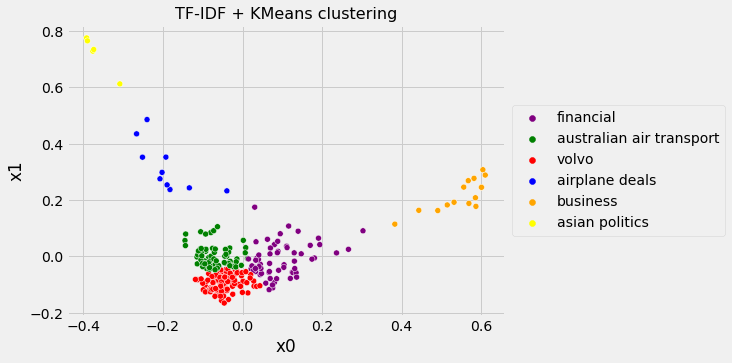

In [72]:
fig, ax = plt.subplots(figsize=(7,5))

plt.title("TF-IDF + KMeans clustering", fontdict={"fontsize": 16})
ax = sns.scatterplot(
    x = docs_text['x0'],
    y = docs_text['x1'],
    hue = docs_text['cluster'],
    data = docs_text,
    legend='full',
    palette = {
        'volvo':'red',
        'business':'orange',
        'asian politics':'yellow',
        'australian air transport':'green',
        'airplane deals':'blue', 
        'financial':'purple'
    })

ax.legend(loc='center left',bbox_to_anchor=(1.00, 0.5))
plt.show()